### [train]

In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

train = pd.read_csv('num_train_data.csv')

train['개봉일'] = pd.to_datetime(train['개봉일'], errors='coerce')
train['개봉년도'] = train['개봉일'].dt.year
train['개봉월'] = train['개봉일'].dt.month
train['개봉요일'] = train['개봉일'].dt.weekday

cat_cols = ['감독이름', '제작국가', '장르']
encoder = LabelEncoder()
for col in cat_cols:
    train[col] = encoder.fit_transform(train[col].fillna("Unknown"))

features = ['감독이름', '제작국가', '장르', '개봉년도', '개봉월', '개봉요일', '누적매출액']
X = train[features]
y = train['누적관객수']

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

params = {
    'max_depth': 6,
    'learning_rate': 0.05,
    'subsample': 0.9,
    'colsample_bytree': 0.7,
    'reg_alpha': 0.5,
    'reg_lambda': 1.0,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'seed': 42
}

model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dvalid, 'valid')],
    early_stopping_rounds=50,
    verbose_eval=50
)

y_pred = model.predict(dvalid)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
mae = mean_absolute_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

print(f"Validation RMSE: {rmse:.4f}")
print(f"Validation MAE: {mae:.4f}")
print(f"Validation R^2: {r2:.4f}")


[0]	train-rmse:1734335.13497	valid-rmse:1535879.97493
[50]	train-rmse:508459.38272	valid-rmse:474524.06261
[100]	train-rmse:206823.75912	valid-rmse:245787.30946
[150]	train-rmse:117128.14711	valid-rmse:189858.74079
[200]	train-rmse:87861.76272	valid-rmse:175467.92203
[250]	train-rmse:74169.95055	valid-rmse:170595.77574
[300]	train-rmse:66374.29950	valid-rmse:167984.82858
[350]	train-rmse:60112.28879	valid-rmse:167166.83544
[400]	train-rmse:55086.30920	valid-rmse:165732.26116
[450]	train-rmse:50736.63581	valid-rmse:165616.87953
[461]	train-rmse:50140.05229	valid-rmse:165563.14201
Validation RMSE: 165563.1325
Validation MAE: 71523.2109
Validation R^2: 0.9884


Validation RMSE: 165563.1325
Validation MAE: 71523.2109
Validation R^2: 0.9884


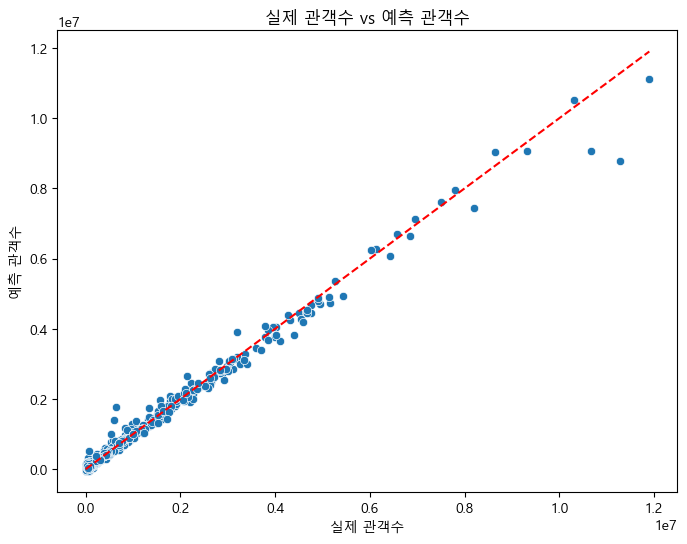

In [21]:
import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns

font_path = "C:/Windows/Fonts/malgun.ttf"
font_name = fm.FontProperties(fname=font_path).get_name()
matplotlib.rc('font', family=font_name)

print(f"Validation RMSE: {rmse:.4f}")
print(f"Validation MAE: {mae:.4f}")
print(f"Validation R^2: {r2:.4f}")

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_valid, y=y_pred)
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')
plt.xlabel("실제 관객수")
plt.ylabel("예측 관객수")
plt.title("실제 관객수 vs 예측 관객수")
plt.show()

### [test] - 관객수 예측하기

In [11]:
import pandas as pd
import numpy as np
import xgboost as xgb

test = pd.read_csv('test_data.csv')

test.rename(columns={'감독': '감독이름'}, inplace=True)

test['개봉일'] = pd.to_datetime(test['개봉일'], errors='coerce')
test['개봉년도'] = test['개봉일'].dt.year
test['개봉월'] = test['개봉일'].dt.month
test['개봉요일'] = test['개봉일'].dt.weekday

test['누적매출액'] = test['누적매출액'].fillna(0)

for col in ['감독이름', '제작국가', '장르']:
    test[col] = test[col].fillna("Unknown")
    test[col] = test[col].apply(lambda x: x if x in encoder.classes_ else "Unknown")
    if "Unknown" not in encoder.classes_:
        encoder.classes_ = np.append(encoder.classes_, "Unknown")
    test[col] = encoder.transform(test[col])

features = ['감독이름', '제작국가', '장르', '개봉년도', '개봉월', '개봉요일', '누적매출액']
X_test = test[features]

dtest = xgb.DMatrix(X_test)

y_test_pred = model.predict(dtest)

test['예측_누적관객수'] = y_test_pred

print(test[['영화명', '예측_누적관객수']].head())

test[['영화명', '예측_누적관객수']].to_csv('test_predictions.csv', index=False, encoding='utf-8-sig')


        영화명       예측_누적관객수
0    태양의 노래   83408.765625
1       좀비딸  110390.820312
2      바이러스   92898.093750
3  우리 둘 사이에  179187.515625
4    엣 더 벤치  179187.515625


In [14]:
test

,영화명,감독이름,제작국가,개봉일,장르,누적관객수,누적매출액,개봉년도,개봉월,개봉요일,예측_누적관객수
0,태양의 노래,15,15,2025-06-11,30,17303.0,1.545620e+08,2025,6,2,8.340877e+04
1,좀비딸,15,15,2025-07-30,166,29892.0,2.921579e+08,2025,7,2,1.103908e+05
2,바이러스,15,15,2025-05-07,30,71790.0,6.431947e+08,2025,5,2,9.289809e+04
3,우리 둘 사이에,15,15,2025-07-30,30,NaN,0.000000e+00,2025,7,2,1.791875e+05
4,엣 더 벤치,15,15,2025-07-30,30,NaN,0.000000e+00,2025,7,2,1.791875e+05
...,...,...,...,...,...,...,...,...,...,...,...
3904,디어스킨,15,15,2020-01-01,97,NaN,0.000000e+00,2020,1,2,1.709449e+05
3905,타발루가와 얼음공주,15,15,2020-01-08,107,NaN,0.000000e+00,2020,1,2,2.283728e+05
3906,닥터 두리틀,15,15,2020-01-08,186,1604127.0,1.343050e+10,2020,1,2,1.680279e+06
3907,스타워즈: 라이즈 오브 스카이워커,15,15,2020-01-08,129,485464.0,4.513763e+09,2020,1,2,6.724769e+05


C:\Users\USER\AppData\Local\Temp\ipykernel_7256\687249257.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10, x='예측_누적관객수', y='영화명', palette='viridis')


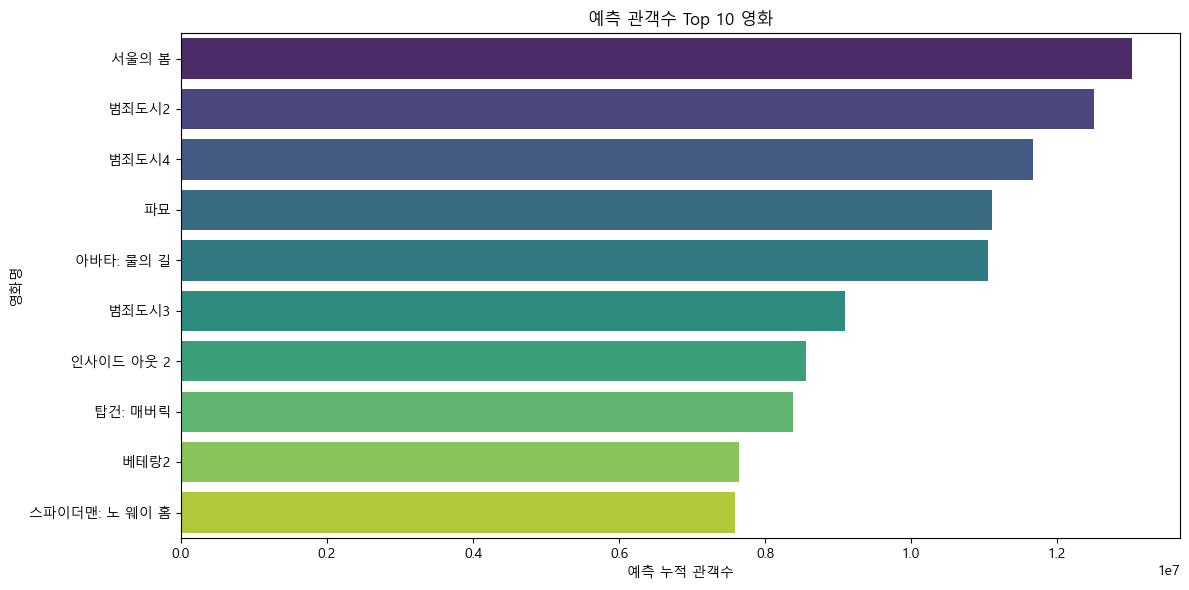

In [18]:
# 상위 10위 영화

import matplotlib.pyplot as plt
import seaborn as sns

top10 = test.sort_values(by='예측_누적관객수', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top10, x='예측_누적관객수', y='영화명', palette='viridis')
plt.title('예측 관객수 Top 10 영화')
plt.xlabel('예측 누적 관객수')
plt.ylabel('영화명')
plt.tight_layout()
plt.show()


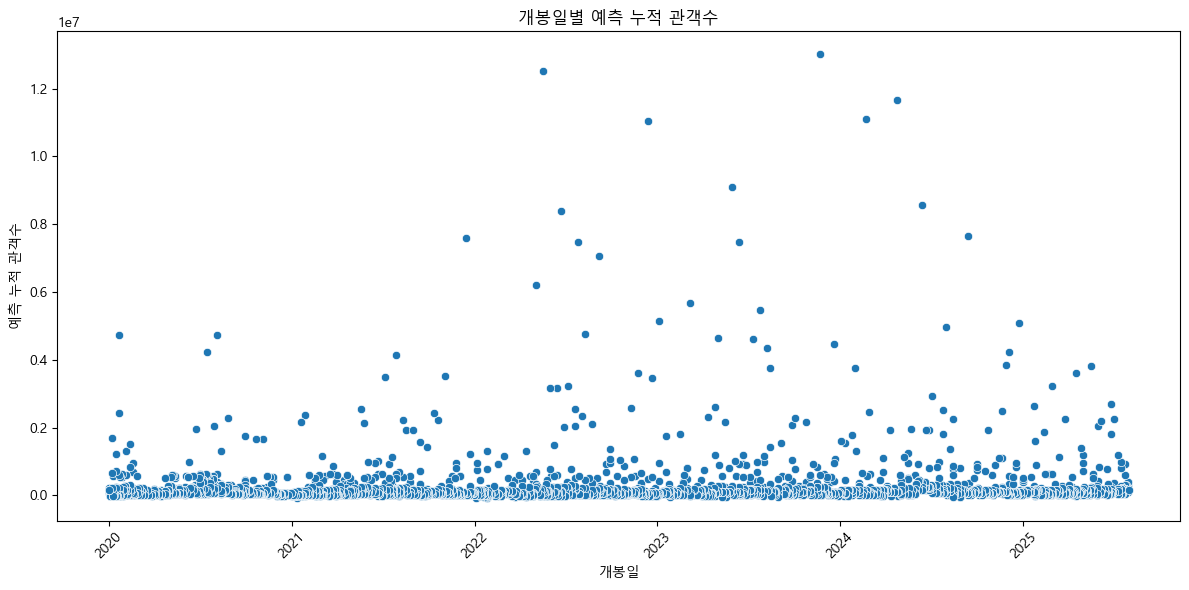

In [20]:
# 산점도
test['개봉일'] = pd.to_datetime(test['개봉일'])

plt.figure(figsize=(12, 6))
sns.scatterplot(data=test, x='개봉일', y='예측_누적관객수')
plt.title('개봉일별 예측 누적 관객수')
plt.xlabel('개봉일')
plt.ylabel('예측 누적 관객수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()